In [1]:
import nest_asyncio
import prompts
import importlib
import state 
import nodes 
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Literal
import os
from openai import OpenAI
from dotenv import load_dotenv
importlib.reload(prompts)
importlib.reload(state)
importlib.reload(nodes)
from nodes import assistant, summarize_packets, execute_tools
from state import HoneypotStateReact
nest_asyncio.apply()


def display_graph(graph, width=500, height=600):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

def is_api_key_valid():
    try:
        client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        response = client.responses.create(
            model="gpt-4o",
            instructions="Test API key",
            input="Test API key",
            max_output_tokens=16
            )
    except Exception as e:
        print(f"Error: {e}")
        return False
    else:
        return True

In [2]:

# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
#  Check the validity of the API key
api_key_valid = is_api_key_valid()
print("API key is valid:", api_key_valid)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"


API key is valid: True


In [3]:
def should_continue(state: HoneypotStateReact) -> Literal["tools", "threat_verification", END]:
    """Determine next action based on the last message"""
    last_message = state.messages[-1]
    
    # If the last message has tool calls, execute them
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # Check if we need to summarize packet data
    if state.network_flows and state.security_events and state.compressed_packets and not state.packet_summary:
        return "threat_verification"

    # Otherwise, we're done
    return END

In [4]:
# Build the graph
def build_react_graph():
    builder = StateGraph(HoneypotStateReact)
    
    # Add nodes
    builder.add_node("assistant", assistant)
    builder.add_node("tools", execute_tools)
    builder.add_node("threat_verification", summarize_packets)
    
    # Add edges
    builder.add_edge(START, "assistant")
    builder.add_conditional_edges("assistant", should_continue)
    builder.add_edge("tools", "assistant")
    builder.add_edge("threat_verification", "assistant")
    
    return builder.compile()


INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:60743/devtools/browser/d2f44197-6551-4cc7-87a5-0db6672b8f9b
INFO:pyppeteer.launcher:terminate chrome process...


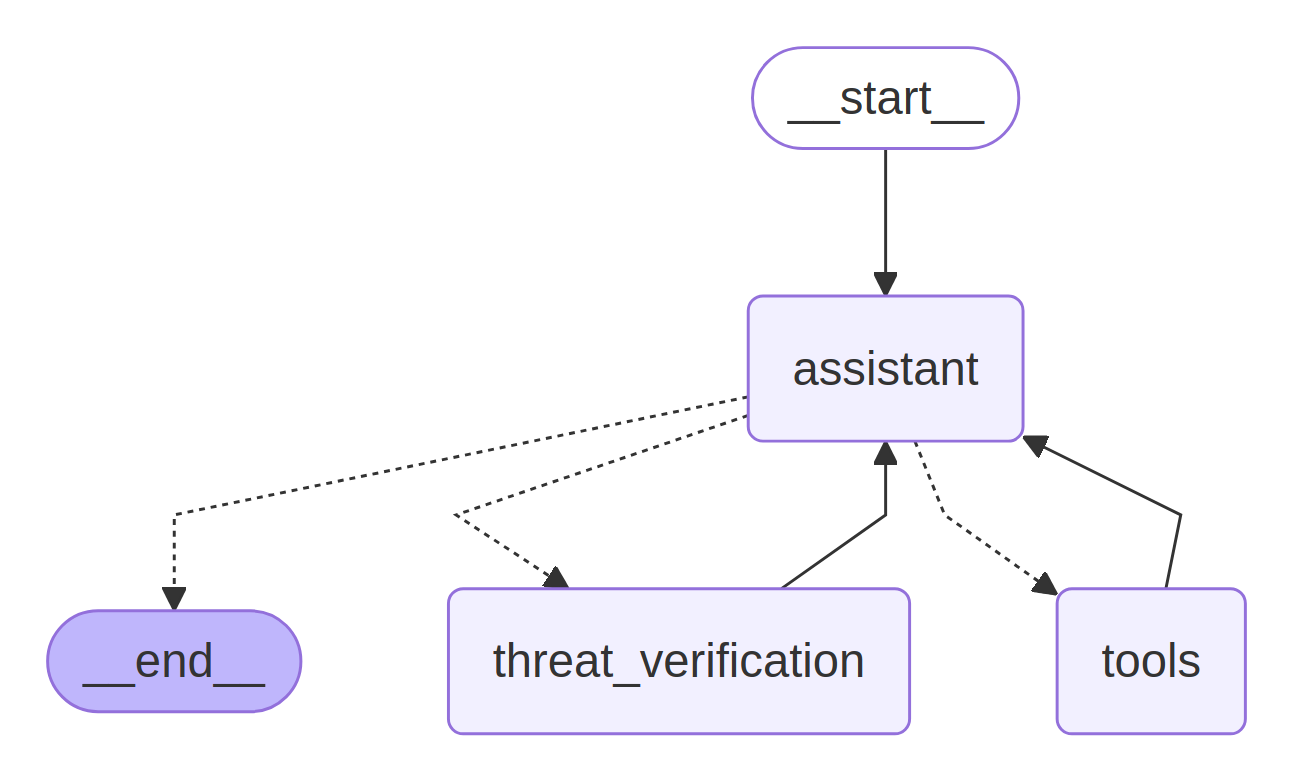

In [5]:
graph = build_react_graph()
display_graph(graph)

In [6]:
# Create an initial state
initial_state = HoneypotStateReact(
    messages="Analyze a time_window=2 for all the tools and compressed_packets(limit=300)"
)
response = graph.invoke(initial_state)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving services status
INFO:tools:Retrieving security events (window: 2 minutes)
INFO:tools:Retrieving network flows (window: 2 minutes)
INFO:tools:Retrieving compressed packets (limit: 300, window: 5)
INFO:tools:Retrieving firewall rules...
INFO:tools:Retrieved 3 threat IPs, 0 command executions, 0 total threats
INFO:tools:Successfully retrieve services health
INFO:tools:Retrieved 300 compressed packets, 10 with threats, 0 with command execution
INFO:tools:Successfully retrieved firewall rules
INFO:tools:Retrieved 38 flows with 3 threat IPs
INFO:tools:Threat details found for IPs: ['172.20.0.2', '172.20.0.6', '192.168.100.2']
INFO:nodes:Network flows: Found threats from 3 IPs with details: ['172.20.0.2', '172.20.0.6', '192.168.100.2']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Extracted 2 threat incidents with payload for 

Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: 192.168.100.2 -> 172.20.0.2:2375
INFO:tools:Adding allow rule: 172.20.0.2 -> 192.168.100.2:None
INFO:tools:Successfully added allow rule
INFO:tools:Successfully added allow rule
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [7]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Analyze a time_window=2 for all the tools and compressed_packets(limit=300)
================================== Ai Message ==================================
Tool Calls:
  check_services_health (call_l6vfveVyaEXN3WAOaObujs7I)
 Call ID: call_l6vfveVyaEXN3WAOaObujs7I
  Args:
  get_security_events (call_51kH003wo4ZuCvt7licPilBG)
 Call ID: call_51kH003wo4ZuCvt7licPilBG
  Args:
    time_window: 2
  get_network_flows (call_soswogG3usRCVGIyfzqdUReI)
 Call ID: call_soswogG3usRCVGIyfzqdUReI
  Args:
    time_window: 2
  get_compressed_packets (call_R5WeWcEu9rHz1tMln9SSvji4)
 Call ID: call_R5WeWcEu9rHz1tMln9SSvji4
  Args:
    limit: 300
  get_firewall_rules (call_v9sHQAQuI44BYsTzTMfh604O)
 Call ID: call_v9sHQAQuI44BYsTzTMfh604O
  Args:
  getDockerContainers (call_5zWX58z2wuzAInauGQyXvELo)
 Call ID: call_5zWX58z2wuzAInauGQyXvELo
  Args:
================================= Tool Message =================================
N